In [7]:
noreg_data = {
    "cifar_resnet": 11.69,
    "imagenet_resnet": 11.56,
    "cifar_convnext": 15.57,
    "imagenet_convnext": 17.38,
}

In [8]:
import pandas as pd
import wandb

api = wandb.Api()

entity = "tunnels-ssl"
project = "01.21"
# Get all runs for the specified project
runs = api.runs(f"{entity}/{project}")


summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict["test/avg_acc_tag"])

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"test_acc": summary_list, "config": config_list, "name": name_list}
)
config_df = pd.json_normalize(runs_df["config"])
df = pd.concat([runs_df.drop(columns=["config"]), config_df], axis=1)
df["data.datasets"] = df["data.datasets"].apply(lambda x: x[0])

In [21]:
dataset = "imagenet"
network = "convnext"

df_a = df[
    (df["data.datasets"].str.contains(dataset))
    & (df["model.network"].str.contains(network))
]

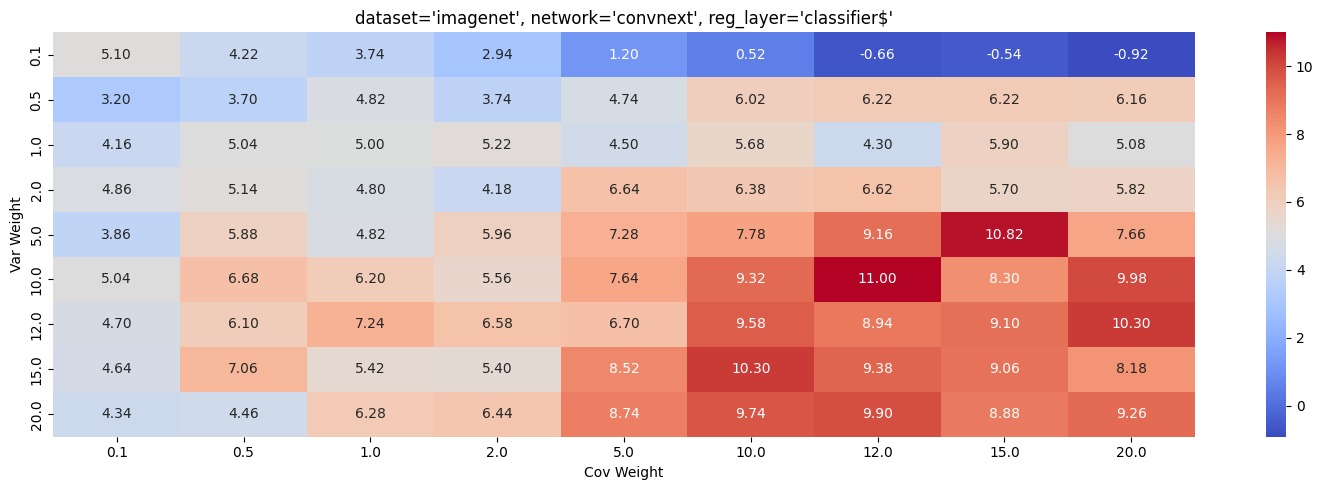

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame creation (for demonstration purposes)
# Get unique values of reg_layers
unique_reg_layers = df_a["training.vcreg.reg_layers"].unique()

# Create a figure for the heatmaps
fig, axes = plt.subplots(1, len(unique_reg_layers), figsize=(15, 5))

if len(unique_reg_layers) == 1:
    axes = [axes]
# Loop through each unique reg_layer to create a heatmap
for i, reg_layer in enumerate(unique_reg_layers):
    # Filter data for the current reg_layer
    filtered_df = df_a[df_a["training.vcreg.reg_layers"] == reg_layer]

    # Create a pivot table for the heatmap
    pivot_table = filtered_df.pivot_table(
        index="training.vcreg.var_weight",
        columns="training.vcreg.cov_weight",
        values="test_acc",
        aggfunc=lambda x: x - noreg_data[f"{dataset}_{network}"],
    )

    # Draw the heatmap
    sns.heatmap(
        pivot_table,
        annot=True,
        cmap="coolwarm",
        ax=axes[i],
        cbar=True,
        fmt=".2f",
    )

    # Set title for each subplot
    axes[i].set_title(f"{dataset=}, {network=}, {reg_layer=}")
    axes[i].set_xlabel("Cov Weight")
    axes[i].set_ylabel("Var Weight")

# Adjust layout
plt.tight_layout()
plt.show()

In [23]:
imagent_convnext = pivot_table.copy()

In [24]:
dataset = "cifar"
network = "convnext"

df_a = df[
    (df["data.datasets"].str.contains(dataset))
    & (df["model.network"].str.contains(network))
]

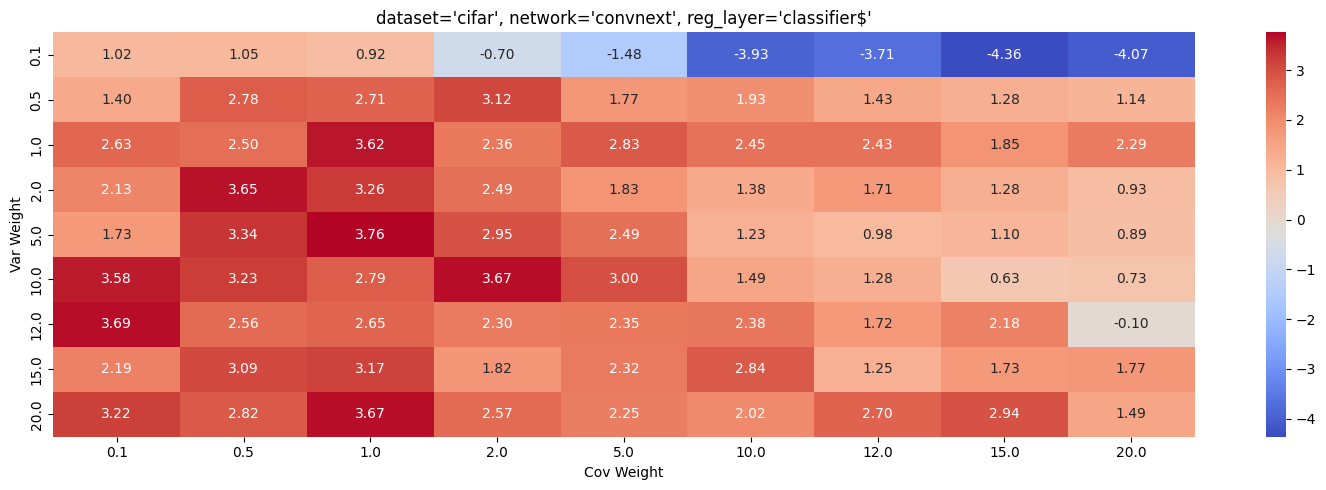

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame creation (for demonstration purposes)
# Get unique values of reg_layers
unique_reg_layers = df_a["training.vcreg.reg_layers"].unique()

# Create a figure for the heatmaps
fig, axes = plt.subplots(1, len(unique_reg_layers), figsize=(15, 5))

if len(unique_reg_layers) == 1:
    axes = [axes]
# Loop through each unique reg_layer to create a heatmap
for i, reg_layer in enumerate(unique_reg_layers):
    # Filter data for the current reg_layer
    filtered_df = df_a[df_a["training.vcreg.reg_layers"] == reg_layer]

    # Create a pivot table for the heatmap
    pivot_table = filtered_df.pivot_table(
        index="training.vcreg.var_weight",
        columns="training.vcreg.cov_weight",
        values="test_acc",
        aggfunc=lambda x: x - noreg_data[f"{dataset}_{network}"],
    )

    # Draw the heatmap
    sns.heatmap(
        pivot_table,
        annot=True,
        cmap="coolwarm",
        ax=axes[i],
        cbar=True,
        fmt=".2f",
    )

    # Set title for each subplot
    axes[i].set_title(f"{dataset=}, {network=}, {reg_layer=}")
    axes[i].set_xlabel("Cov Weight")
    axes[i].set_ylabel("Var Weight")

# Adjust layout
plt.tight_layout()
plt.show()

In [26]:
cifar_convnext = pivot_table.copy()

In [29]:
import numpy as np

In [45]:
xx = (cifar_convnext + imagent_convnext).reset_index()
melted_table = pd.melt(
    xx,
    id_vars=["training.vcreg.var_weight"],  # Variables to keep fixed
    var_name="training.vcreg.cov_weight",  # Name for the column created from columns
    value_name="test_acc",  # Name for the values column
)

In [46]:
melted_table

,training.vcreg.var_weight,training.vcreg.cov_weight,test_acc
0,0.1,0.1,6.12
1,0.5,0.1,4.60
2,1.0,0.1,6.79
3,2.0,0.1,6.99
4,5.0,0.1,5.59
...,...,...,...
76,5.0,20.0,8.55
77,10.0,20.0,10.71
78,12.0,20.0,10.20
79,15.0,20.0,9.95


In [ ]:
melted = melted_table.pivot_table(
    index="training.vcreg.var_weight",
    columns="training.vcreg.cov_weight",
    values="test_acc",
    aggfunc=lambda x: f"{np.mean(x):.2f}±{np.var(x):.2f}",
)
melted

training.vcreg.cov_weight,0.1,0.5,1.0,2.0,5.0,10.0,12.0,15.0,20.0
training.vcreg.var_weight,,,,,,,,,
0.1,6.12±0.00,5.27±0.00,4.66±0.00,2.24±0.00,-0.28±0.00,-3.41±0.00,-4.37±0.00,-4.90±0.00,-4.99±0.00
0.5,4.60±0.00,6.48±0.00,7.53±0.00,6.86±0.00,6.51±0.00,7.95±0.00,7.65±0.00,7.50±0.00,7.30±0.00
1.0,6.79±0.00,7.54±0.00,8.62±0.00,7.58±0.00,7.33±0.00,8.13±0.00,6.73±0.00,7.75±0.00,7.37±0.00
2.0,6.99±0.00,8.79±0.00,8.06±0.00,6.67±0.00,8.47±0.00,7.76±0.00,8.33±0.00,6.98±0.00,6.75±0.00
5.0,5.59±0.00,9.22±0.00,8.58±0.00,8.91±0.00,9.77±0.00,9.01±0.00,10.14±0.00,11.92±0.00,8.55±0.00
10.0,8.62±0.00,9.91±0.00,8.99±0.00,9.23±0.00,10.64±0.00,10.81±0.00,12.28±0.00,8.93±0.00,10.71±0.00
12.0,8.39±0.00,8.66±0.00,9.89±0.00,8.88±0.00,9.05±0.00,11.96±0.00,10.66±0.00,11.28±0.00,10.20±0.00
15.0,6.83±0.00,10.15±0.00,8.59±0.00,7.22±0.00,10.84±0.00,13.14±0.00,10.63±0.00,10.79±0.00,9.95±0.00
20.0,7.56±0.00,7.28±0.00,9.95±0.00,9.01±0.00,10.99±0.00,11.76±0.00,12.60±0.00,11.82±0.00,10.75±0.00


In [30]:
sns.heatmap(
    cifar_convnext + imagent_convnext,
    annot=True,
    cmap="coolwarm",
    cbar=True,
    fmt=".2f",
)

ValueError: Must pass 2-d input. shape=()

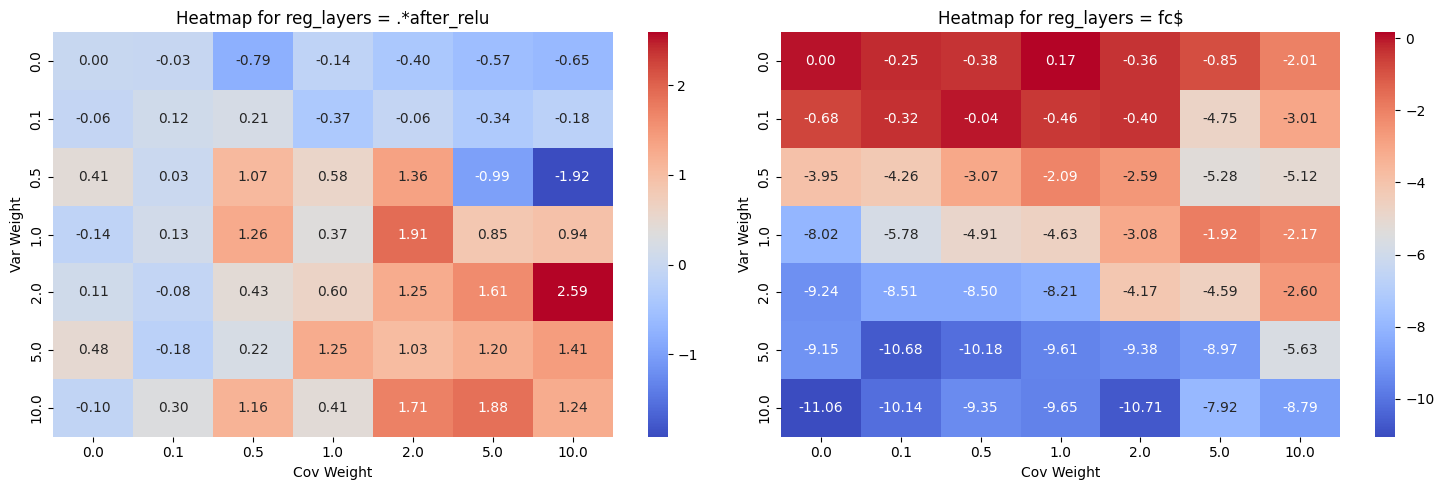

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame creation (for demonstration purposes)
# Get unique values of reg_layers
unique_reg_layers = df["training.vcreg.reg_layers"].unique()

# Create a figure for the heatmaps
fig, axes = plt.subplots(1, len(unique_reg_layers), figsize=(15, 5))

# Loop through each unique reg_layer to create a heatmap
for i, reg_layer in enumerate(unique_reg_layers):
    # Filter data for the current reg_layer
    filtered_df = df[df["training.vcreg.reg_layers"] == reg_layer]

    # Create a pivot table for the heatmap
    pivot_table = filtered_df.pivot_table(
        index="training.vcreg.var_weight",
        columns="training.vcreg.cov_weight",
        values="test_acc",
        aggfunc=lambda x: x - 11.69,
    )

    # Draw the heatmap
    sns.heatmap(
        pivot_table,
        annot=True,
        cmap="coolwarm",
        ax=axes[i],
        cbar=True,
        fmt=".2f",
    )

    # Set title for each subplot
    axes[i].set_title(f"Heatmap for reg_layers = {reg_layer}")
    axes[i].set_xlabel("Cov Weight")
    axes[i].set_ylabel("Var Weight")

# Adjust layout
plt.tight_layout()
plt.show()

In [31]:
pivot_table

training.vcreg.cov_weight,0.0,0.1,0.5,1.0,2.0,5.0,10.0
training.vcreg.var_weight,,,,,,,
0.0,0.00,-0.25,-0.38,0.17,-0.36,-0.85,-2.01
0.1,-0.68,-0.32,-0.04,-0.46,-0.40,-4.75,-3.01
0.5,-3.95,-4.26,-3.07,-2.09,-2.59,-5.28,-5.12
1.0,-8.02,-5.78,-4.91,-4.63,-3.08,-1.92,-2.17
2.0,-9.24,-8.51,-8.50,-8.21,-4.17,-4.59,-2.60
5.0,-9.15,-10.68,-10.18,-9.61,-9.38,-8.97,-5.63
10.0,-11.06,-10.14,-9.35,-9.65,-10.71,-7.92,-8.79


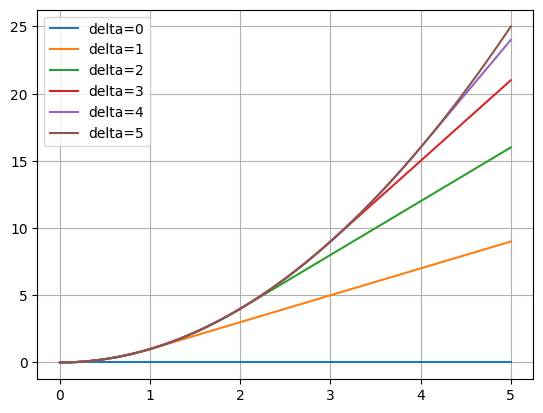

In [65]:
import numpy as np
import matplotlib.pyplot as plt


# Define the smooth_l1 function
def smooth_l1(x, delta):
    abs_x = np.abs(x)
    return np.where(abs_x <= delta, x**2, 2 * delta * abs_x - delta**2)

    # Set delta
    delta = 1


for delta in [0, 1, 2, 3, 4, 5]:
    # Generate x values
    x_values = np.linspace(0, 5, 400)
    y_values = smooth_l1(x_values, delta)

    # Create the plot
    plt.plot(x_values, y_values, label=f"{delta=}")
plt.plot(x_values, y_values, label=f"{delta=}")
plt.legend()
plt.grid()
plt.show()